In [0]:
## helper.py

import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
from torch.autograd import Variable


def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        ax2.set_yticklabels(['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from collections import OrderedDict
import matplotlib.pyplot as plt

import torch 
from torch import nn, optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models

In [30]:
!wget https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
!mkdir flowers
!tar -xvzf flower_data.tar.gz -C flowers

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

--2019-07-23 16:54:35--  https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.121.2
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.121.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344873452 (329M) [application/x-gzip]
Saving to: ‘flower_data.tar.gz.2’

flower_data.tar.gz. 100%[===================>] 328.90M  81.0MB/s    in 4.0s    

2019-07-23 16:54:40 (81.3 MB/s) - ‘flower_data.tar.gz.2’ saved [344873452/344873452]

mkdir: cannot create directory ‘flowers’: File exists
train/
train/101/
train/101/image_07994.jpg
train/101/image_07960.jpg
train/101/image_07947.jpg
train/101/image_07993.jpg
train/101/image_07945.jpg
train/101/image_07973.jpg
train/101/image_07972.jpg
train/101/image_07991.jpg
train/101/image_07977.jpg
train/101/image_07982.jpg
train/101/image_07948.jpg
train/101/image_07969.jpg
train/101/image_07966.jpg
train/101/image_07957.jpg
train/101/image_07979.jpg

In [0]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
testval_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])

image_trainset = datasets.ImageFolder(train_dir, transform=train_transforms)
image_testset = datasets.ImageFolder(test_dir, transform=testval_transforms)
image_valset = datasets.ImageFolder(valid_dir, transform=testval_transforms)

image_trainloader = torch.utils.data.DataLoader(image_trainset, batch_size=64, shuffle=True)
image_testloader = torch.utils.data.DataLoader(image_testset, batch_size=64, shuffle=True)
image_valloader = torch.utils.data.DataLoader(image_valset, batch_size=64, shuffle=True)

In [0]:
fepochs = 1
lr = 0.001
print_every = 10

hidden_layers = [10240, 1024]
output_size = 102

def make_model(structure, hidden_layers, lr):
    if structure=="densenet161":
        model = models.densenet161(pretrained=True)
        input_size = 2208
    else:
        model = models.vgg16(pretrained=True)
        input_size = 25088
      
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(OrderedDict([
                              ('dropout',nn.Dropout(0.5)),
                              ('fc1', nn.Linear(input_size, hidden_layers[0])),
                              ('relu1', nn.ReLU()),
                              ('fc2', nn.Linear(hidden_layers[0], hidden_layers[1])),
                              ('relu2', nn.ReLU()),
                              ('fc3', nn.Linear(hidden_layers[1], output_size)),
                              ('output', nn.LogSoftmax(dim=1))
                              ]))
    
    return model

model = make_model('vgg16', hidden_layers, lr)

In [33]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=lr)
using_gpu = torch.cuda.is_available()

using_gpu

True

In [0]:
def cal_accuracy(model, dataloader):
    validation_loss = 0
    accuracy = 0
    for i, (inputs,labels) in enumerate(dataloader):
      optimizer.zero_grad()

      if(using_gpu):
        inputs, labels = inputs.to('cuda') , labels.to('cuda')
        model.to('cuda')
      else:
        inputs, labels = inputs.to('cpu') , labels.to('cpu')
        model.to('cpu')

      with torch.no_grad():    
        outputs = model.forward(inputs)
        validation_loss = criterion(outputs,labels)
        ps = torch.exp(outputs).data
        equality = (labels.data == ps.max(1)[1])
        accuracy += equality.type_as(torch.FloatTensor()).mean()
                    
    validation_loss = validation_loss / len(dataloader)
    accuracy = accuracy /len(dataloader)
    
    return validation_loss, accuracy

In [35]:
def my_DLM(model, image_trainloader, image_valloader, epochs, print_every, criterion, optimizer):
  steps = 0

  if(using_gpu):
#     change to cuda
    model.to('cuda')

  for e in range(epochs):
      running_loss = 0
      for ii, (inputs, labels) in enumerate(image_trainloader):
          steps += 1

          if(using_gpu):
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
          else:
            inputs, labels = inputs.to('cpu'), labels.to('cpu')

          optimizer.zero_grad()
1
          # Forward and backward passes
          outputs = model.forward(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()

          if steps % print_every == 0:
              model.eval()
              val_loss, train_ac = cal_accuracy(model, image_valloader)
              print("Epoch: {}/{}... | ".format(e+1, epochs),
                    "Loss: {:.4f} | ".format(running_loss/print_every),
                    "Validation Loss {:.4f} | ".format(val_loss),
                    "Accuracy {:.4f}".format(train_ac))

              running_loss = 0
              
my_DLM(model, image_trainloader, image_valloader, fepochs, print_every, criterion, optimizer)

Epoch: 1/1... |  Loss: 5.7823 |  Validation Loss 0.3461 |  Accuracy 0.0427
Epoch: 1/1... |  Loss: 4.4293 |  Validation Loss 0.3071 |  Accuracy 0.1085
Epoch: 1/1... |  Loss: 4.1131 |  Validation Loss 0.3076 |  Accuracy 0.1887
Epoch: 1/1... |  Loss: 3.5916 |  Validation Loss 0.2106 |  Accuracy 0.2969
Epoch: 1/1... |  Loss: 2.8153 |  Validation Loss 0.1789 |  Accuracy 0.3817
Epoch: 1/1... |  Loss: 2.5098 |  Validation Loss 0.1562 |  Accuracy 0.4313
Epoch: 1/1... |  Loss: 2.5057 |  Validation Loss 0.1447 |  Accuracy 0.4713
Epoch: 1/1... |  Loss: 2.1349 |  Validation Loss 0.1584 |  Accuracy 0.5283
Epoch: 1/1... |  Loss: 2.0656 |  Validation Loss 0.1205 |  Accuracy 0.5666
Epoch: 1/1... |  Loss: 1.8810 |  Validation Loss 0.1276 |  Accuracy 0.5706


In [36]:
def testing(dataloader):
    model.eval()
    model.to('cuda')
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in image_testloader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            _ , prediction = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (prediction == labels.data).sum().item()
        print('Accuracy on the test set: %d %%' % (100 * correct / total))   


testing(image_testloader)

Accuracy on the test set: 59 %


torch.Size([64, 3, 224, 224])


RuntimeError: ignored

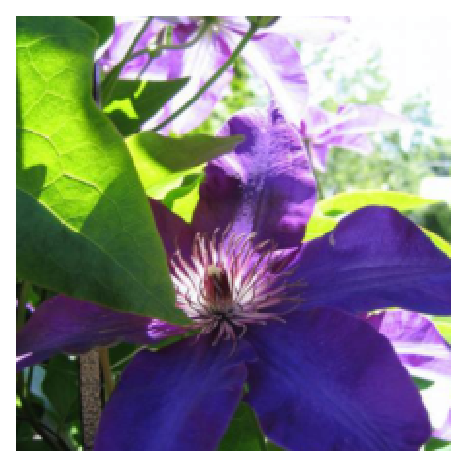

In [53]:
images, label = next(iter(image_testloader))

imshow(images[0,:])
print(images.shape)

img = images[0].reshape((64, 3, 224, 224))

with torch.no_grad():
  logps = model.forward(img)

ps = torch.exp(logps)

plt.plot(loss_rate,label="Loss Rate")
plt.legend(frameon=False)

view_classify(img.view(1,28,28), ps)

# Saving the model

In [0]:
model.class_to_idx = image_trainset.class_to_idx

In [0]:
state = {
            'structure' :'vgg16',
            'learning_rate': lr,
            'epochs': fepochs,
            'hidden_layers':hidden_layers,
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx
}
torch.save(state, 'checkpoint.pth')

In [0]:
def loading_checkpoint(path):
    # Loading the parameters
    state = torch.load(path)
    lr = state['learning_rate']
    structure = state['structure']
    hidden_layers = state['hidden_layers']
    epochs = state['epochs']
    
    # Building the model from checkpoints
    model = make_model(structure, hidden_layers, lr)
    class_to_idx = state['class_to_idx']
    model.load_state_dict(state['state_dict'])
    
loading_checkpoint('checkpoint.pth')